In [1]:
! mkdir -p data

Download https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz
and unarchive it in `data` folder.

In [2]:
! ls ./data/mini_newsgroups/

alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc
misc.forsale		  sci.med


In [3]:
from pyspark.sql import functions as fun

texts = spark.read\
  .format("text")\
  .option("recursiveFileLookup", "true")\
  .option("wholetext", "true")\
  .load("data/mini_newsgroups/")\
  .withColumnRenamed("value", "text")\
  .withColumn("filename", fun.input_file_name()) # TIP: https://www.youtube.com/watch?v=7jxFffeQHpQ

texts.show(n=5, truncate=120, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------
 text     | Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!spool.mu.edu!nigel.msen.com!sdd.... 
 filename | file:///home/mehdi/Projects/Devocative/JupyterLab/src/spark-nlp/data/mini_newsgroups/sci.electronics/53569               
-RECORD 1----------------------------------------------------------------------------------------------------------------------------
 text     | Newsgroups: comp.os.ms-windows.misc\nPath: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.o... 
 filename | file:///home/mehdi/Projects/Devocative/JupyterLab/src/spark-nlp/data/mini_newsgroups/comp.os.ms-windows.misc/9704        
-RECORD 2----------------------------------------------------------------------------------------------------------------------------
 text     | Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:3885

In [4]:
texts.limit(5).toPandas()

,text,filename
0,Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...,file:///home/mehdi/Projects/Devocative/Jupyter...
1,Newsgroups: comp.os.ms-windows.misc\nPath: can...,file:///home/mehdi/Projects/Devocative/Jupyter...
2,Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:...,file:///home/mehdi/Projects/Devocative/Jupyter...
3,Xref: cantaloupe.srv.cs.cmu.edu comp.windows.x...,file:///home/mehdi/Projects/Devocative/Jupyter...
4,Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:...,file:///home/mehdi/Projects/Devocative/Jupyter...


In [5]:
import os

parts = ("file://" + os.path.dirname(os.path.realpath("data/mini_newsgroups"))).split("/")
print(parts)

['file:', '', '', 'home', 'mehdi', 'Projects', 'Devocative', 'JupyterLab', 'src', 'spark-nlp', 'data']


In [6]:
texts3col = texts.withColumn("newsgroup", fun.split("filename", "/").getItem(len(parts) + 1))

texts3col.limit(5).toPandas()

,text,filename,newsgroup
0,Path: cantaloupe.srv.cs.cmu.edu!rochester!udel...,file:///home/mehdi/Projects/Devocative/Jupyter...,sci.electronics
1,Newsgroups: comp.os.ms-windows.misc\nPath: can...,file:///home/mehdi/Projects/Devocative/Jupyter...,comp.os.ms-windows.misc
2,Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:...,file:///home/mehdi/Projects/Devocative/Jupyter...,comp.graphics
3,Xref: cantaloupe.srv.cs.cmu.edu comp.windows.x...,file:///home/mehdi/Projects/Devocative/Jupyter...,comp.windows.x
4,Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:...,file:///home/mehdi/Projects/Devocative/Jupyter...,comp.graphics


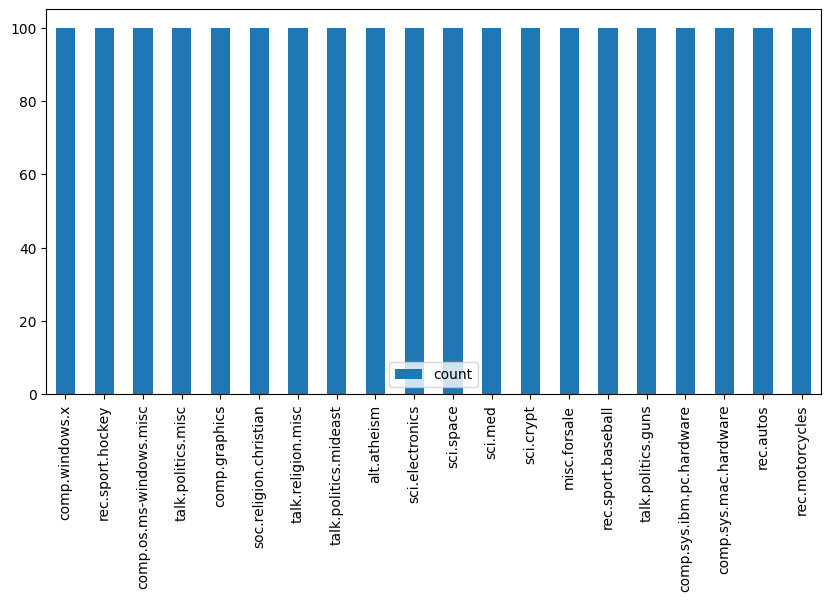

In [7]:
import matplotlib.pyplot as plt

newsgroup_counts = texts3col.groupBy("newsgroup").count().toPandas()

newsgroup_counts.plot(kind='bar', figsize=(10, 5))
plt.xticks(
    ticks=range(len(newsgroup_counts)), 
    labels=newsgroup_counts['newsgroup']
)
plt.show()

In [13]:
! mkdir -p models

Download pipline file from https://nlp.johnsnowlabs.com/2022/06/24/explain_document_ml_en_3_0.html and extract it in `models` folder.

In [14]:
from sparknlp.pretrained import PretrainedPipeline

In [15]:
pipeline = PretrainedPipeline.from_disk("models/explain_document_ml_en_4.0.0_3.0_1656066222624")

In [16]:
pipeline.annotate('Hellu wrold!')

{'document': ['Hellu wrold!'],
 'spell': ['Hello', 'world', '!'],
 'pos': ['UH', 'NN', '.'],
 'lemmas': ['Hello', 'world', '!'],
 'token': ['Hellu', 'wrold', '!'],
 'stems': ['hello', 'world', '!'],
 'sentence': ['Hellu wrold!']}

In [17]:
annot_texts = pipeline.transform(texts)

annot_texts.printSchema()

root
 |-- text: string (nullable = true)
 |-- filename: string (nullable = false)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-

In [25]:
annot_texts.show(n=2, truncate=110, vertical=True)

23/03/24 01:45:12 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


-RECORD 0------------------------------------------------------------------------------------------------------------------
 text     | Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!spool.mu.edu!nigel.mse... 
 filename | file:///home/mehdi/Projects/Devocative/JupyterLab/src/spark-nlp/data/mini_newsgroups/sci.electronics/53569     
 document | [{document, 0, 72995, Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!... 
 sentence | [{document, 0, 264, Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!sp... 
 token    | [{token, 0, 3, Path, {sentence -> 0}, []}, {token, 4, 4, :, {sentence -> 0}, []}, {token, 6, 139, cantaloup... 
 spell    | [{token, 0, 3, Path, {confidence -> 1.0, sentence -> 0}, []}, {token, 4, 4, :, {confidence -> 0.0, sentence... 
 lemmas   | [{token, 0, 3, Path, {confidence -> 1.0, sentence -> 0}, []}, {token, 4, 4, :, {confidence -> 0.0, sentence... 
 stems  

In [26]:
from sparknlp import Finisher

finisher = Finisher()
# taking the lemma column
finisher = finisher.setInputCols(['stems'])
# seperating lemmas by a single space
finished_texts_df = finisher.transform(annot_texts)
finished_texts_df.show(n=1, truncate=110, vertical=True)

23/03/24 01:45:40 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


-RECORD 0------------------------------------------------------------------------------------------------------------------------
 text           | Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!spool.mu.edu!nigel.mse... 
 filename       | file:///home/mehdi/Projects/Devocative/JupyterLab/src/spark-nlp/data/mini_newsgroups/sci.electronics/53569     
 finished_stems | [path, :, cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!spool.mu.edu!nigel... 
only showing top 1 row



In [27]:
finished_texts_df.select('finished_stems').take(1)

23/03/24 01:46:39 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


[Row(finished_stems=['path', ':', 'cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!howland.reston.ans.net!spool.mu.edu!nigel.msen.com!sdd.hp.com!crash!cmkrnl!jeh', 'from', ':', 'jeh@cmkrnl.com', 'newsgroup', ':', 'sci.electron', 'subject', ':', 'electr', 'wire', 'faq', '(', 'wa', ':', 'a', 'question', 'about', '120vac', 'outlet', 'wire', '.', '.', 'message-id', ':', '<1993apr15.213330.1836@cmkrnl.com>', 'date', ':', '15', 'apr', '93', '21:33:30', 'pdt', 'refer', ':', '<1993apr14.172145.27458@ecsvax.uncecs.edu>', 'reply-to', ':', 'wirefaq@ferret.ocunix.on.ca', 'followup-to', ':', 'poster', 'keyword', ':', '120', '240', 'ac', 'outlet', 'wire', 'power', 'shock', 'gfci', 'expir', ':', '15', 'mai', '93', '21:35:16', 'pdt', 'distribut', ':', 'world', 'organ', ':', 'kerner', 'mode', 'system', ',', 'san', 'diego', ',', 'ca', 'line', ':', '1547', 'sinc', 'electr', 'wire', 'question', 'do', 'turn', 'up', 'from', 'time', 'to', 'time', 'on', 'sci.electron', '(', 'and', 'the', 'answer', "ar